In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
import seaborn as sns

plt.style.use(["science", "nature"])
%matplotlib inline

from pycm import ConfusionMatrix
from sklearn.model_selection import train_test_split

from gptchem.formatter import MOFSynthesisRecommenderFormatter
from gptchem.querier import Querier
from gptchem.tuner import Tuner

In [3]:
df = pd.read_csv("BAN_solvents_20230126.csv")

In [67]:
df.tail()

,ligand name,T [°C],t [h],solvent1,V/V solvent1 [ ],solvent2,V/V solvent2 [ ],solvent3,V/V solvent3 [ ],inorganic salt,metal,additional,reported,outcome,score,successful
480,"(S)-4′-(1-carboxyethoxy)-[1,1′-biphenyl]-4-car...",120.0,72.00,acetonitrile,0.8,water,0.2,NaN,NaN,Zn(NO3)2·6H2O,Zn,NaN,10.1039/c7ra00337d,sucessful,1.0,1
481,(S)-6-(1-carboxyethoxy)-2-naphthoic acid,140.0,72.00,acetonitrile,0.8,water,0.2,NaN,NaN,Zn(NO3)2·6H2O,Zn,NaN,10.1039/c7ra00337d,sucessful,1.0,1
482,"4′-(1-carboxyethoxy)-[1,1′-biphenyl]-3,5-dicar...",120.0,72.00,acetonitrile,0.5,water,0.5,NaN,NaN,CoCl2·6H2O,Co,NaOH,10.1039/c9nj05766h,sucessful,1.0,1
483,"N,N′-bis(4-cyanophenyl)-(1R,2R)-diaminocyclohe...",25.0,60.00,dichloromethane,1.0,NaN,NaN,NaN,NaN,[Cu(MeCN)4]PF6,Cu,NaN,10.1021/cg049781w,sucessful,1.0,1
484,"N,N′-bis(4-cyanophenyl)-(1R,2R)-diaminocyclohe...",30.0,0.08,acetone,1.0,NaN,NaN,NaN,NaN,AgClO4·H2O,Ag,NaN,10.1039/b316931f,sucessful,1.0,1


In [5]:
df["outcome"].unique()

array(['successful', 'byproduct', 'failed', 'contaminated',
       'conatminated', 'poor', 'poor BET', 'poor yield', 'incompatible',
       'unknown pahse', 'succesful', 'unknown phase', 'sucessful',
       'modest yield', 'byproduct likely', 'contamination likely',
       'delayed', 'good', 'discarded', 'amorphous', 'poor crystallinity',
       nan], dtype=object)

In [6]:
df["successful"] = df["score"] > 0.6

In [7]:
df["successful"] = df["successful"].astype(int)

<AxesSubplot: >

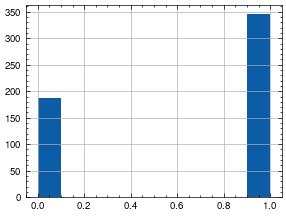

In [8]:
df["successful"].hist()

(array([ 82.,  15.,   7.,   1.,  24.,  10.,   6.,   0.,   3., 337.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

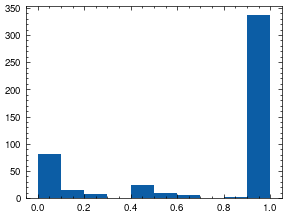

In [9]:
plt.hist(df["score"])

In [10]:
formatter = MOFSynthesisRecommenderFormatter(score_column="successful")

In [11]:
formatted = formatter(df)

In [68]:
formatted.iloc[0]["prompt"]

'What is the sucess of a reaction of (1R,3S)-1,2,2-trimethyl-3-(pyridin-4-ylcarbamoyl)cyclopentanecarboxylic acid with Zn(NO3)2·6H2O in 0.86 methanol and 0.14 water   at 100.0C for 48.0h###'

In [13]:
formatted.iloc[1]["completion"]

' 1@@@'

In [14]:
dois = df["reported"].unique()

train, test = train_test_split(dois, train_size=0.8, random_state=5)

In [15]:
train_data = df[df["reported"].isin(train)]
test_data = df[df["reported"].isin(test)]

In [16]:
train_formatted = formatter(train_data)
test_formatted = formatter(test_data)

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/formatter.py:841: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[self.ligand_column] + [self.inorganic_salt_column], inplace=True)
/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/formatter.py:841: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[self.ligand_column] + [self.inorganic_salt_column], inplace=True)


<AxesSubplot: >

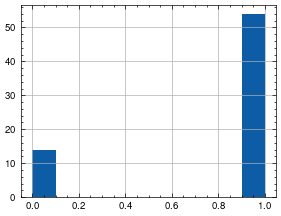

In [17]:
test_formatted["label"].hist()

<AxesSubplot: >

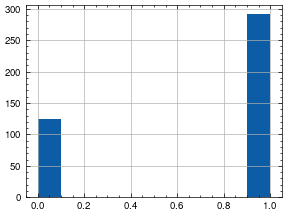

In [18]:
train_formatted["label"].hist()

In [19]:
tuner = Tuner(n_epochs=8, learning_rate_multiplier=0.02, wandb_sync=False)
tuner(train_formatted)

Upload progress: 100%|██████████| 174k/174k [00:00<00:00, 95.3Mit/s]


Uploaded file from /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/03_classification/mof_solvent/out/20230130_084320/train.jsonl: file-OhAEaNYDGbLZzXusl2Mz3QkE


{'base_model': 'ada',
 'batch_size': None,
 'n_epochs': 8,
 'learning_rate_multiplier': 0.02,
 'run_name': None,
 'wandb_sync': False,
 'outdir': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/03_classification/mof_solvent/out/20230130_084320',
 'train_filename': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/03_classification/mof_solvent/out/20230130_084320/train.jsonl',
 'valid_filename': 'None',
 'model_name': 'ada:ft-lsmoepfl-2023-01-30-08-02-53',
 'ft_id': 'ft-jlfm8yStmfFf4xzabbpMCCeM',
 'date': '20230130_090344',
 'train_file_id': 'file-OhAEaNYDGbLZzXusl2Mz3QkE',
 'valid_file_id': None}

In [21]:
querier = Querier("ada:ft-lsmoepfl-2023-01-30-08-02-53")

In [22]:
predictions = querier(test_formatted)

In [23]:
from gptchem.extractor import ClassificationExtractor

In [24]:
predictions

{'choices': [' 0',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 0',
  ' 1',
  ' 0',
  ' 1',
  ' 0',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 1',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 0',
  ' 1',
  ' 1',
  ' 1',
  ' 1',
  ' 1'],
 'logprobs': [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,


In [26]:
extracted = ClassificationExtractor()(predictions)

In [27]:
extracted

(#68) [0,1,1,1,1,1,1,0,1,0...]

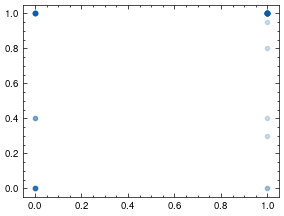

In [28]:
plt.scatter(extracted, test_data["score"], alpha=0.2)

In [54]:
cm = ConfusionMatrix(actual_vector=test_formatted["label"].values, predict_vector=list(extracted))

In [55]:
print(cm)

Predict  0        1        
Actual
0        10       4        

1        14       40       





Overall Statistics : 

95% CI                                                            (0.63043,0.84016)
ACC Macro                                                         0.73529
ARI                                                               0.18998
AUNP                                                              0.72751
AUNU                                                              0.72751
Bangdiwala B                                                      0.62684
Bennett S                                                         0.47059
CBA                                                               0.5787
CSI                                                               0.39039
Chi-Squared                                                       10.07953
Chi-Squared DF                                                    1
Conditional Entropy                                           

In [56]:
len(df)

485

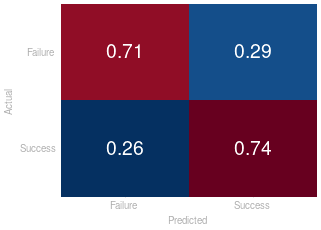

In [64]:
with plt.style.context(matplotx.styles.dufte):
    sns.heatmap(
        pd.DataFrame(cm.normalized_matrix.values()),
        cmap="RdBu_r",
        annot=True,
        fmt=".2f",
        cbar=False,
    )
    plt.xlabel("Predicted", labelpad=4)
    plt.ylabel("Actual", labelpad=4)
    plt.xticks([0.5, 1.5], ["Failure", "Success"], rotation=0)
    plt.yticks([0.5, 1.5], ["Failure", "Success"], rotation=0)
    plt.savefig("balasz_confusion_matrix.pdf", bbox_inches="tight")

In [47]:
cm.normalized_matrix.values()

dict_values([{0: 0.71429, 1: 0.28571}, {0: 0.25926, 1: 0.74074}])

In [65]:
cm.Kappa

0.35983263598326376

In [66]:
print(cm)

Predict  0        1        
Actual
0        10       4        

1        14       40       





Overall Statistics : 

95% CI                                                            (0.63043,0.84016)
ACC Macro                                                         0.73529
ARI                                                               0.18998
AUNP                                                              0.72751
AUNU                                                              0.72751
Bangdiwala B                                                      0.62684
Bennett S                                                         0.47059
CBA                                                               0.5787
CSI                                                               0.39039
Chi-Squared                                                       10.07953
Chi-Squared DF                                                    1
Conditional Entropy                                           

In [80]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [81]:
oh = LabelEncoder()

In [84]:
oh.fit_transform(df["ligand name"].values.reshape(-1, 1))

array([  1, 108,  39,  39,   2, 105, 105, 105, 105, 105, 105, 105, 105,
       105, 105, 105, 105, 105, 105,   3,   3,   3,   3,   3,   3, 103,
       103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 105,  68,
        58,  92,  92,  92,  42,  42,  42,  42, 103,  68,  68,   3,   3,
       105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
       105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
       105, 105, 105, 105, 105, 105, 105, 105, 105,  65,  59,  40,  56,
        52, 101, 103, 103, 103, 103,  86,  86,  87,  55,  55,  55,  89,
        89,  45, 106,  80,  91, 105,  65,  59,  59,  59,  59,  59,  80,
        91,  80,  91,  59,  59,  59,  59,  80, 106,  65,  65,  52,  65,
         7,  59, 102, 102, 102, 105,  60, 105,  64,   7, 109,  67,  94,
         7, 105,  65,  61,   7, 102,  44, 104,  93,  91, 105,  62, 100,
       103,  40,  84,  43,  82,  65, 105,  65,  85, 103, 103, 103, 103,
       103,  97,  63,  98,  83,  73,  90,   0,   5,   6,   4,   